In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(40)   
tf.random.set_seed(40)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[45599:53199] 
Y_train_SS = Y_train_SS[45599:53199]
Y_train_V = Y_train_V[45599:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 7390
Validation samples: 7570
Testing samples: 15140


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define MLP
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate 
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           8256        ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 32)           2080        ['dense_8[0][0]']                
                                                                                            

Train on 7390 samples, validate on 7570 samples
Epoch 1/100
7200/7390 [============================>.] - ETA: 0s - loss: 0.0906 - dense_12_loss: 0.0796 - dense_13_loss: 0.0110 - dense_12_mse: 0.0796 - dense_13_mse: 0.0110

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.03670, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 3s 430us/sample - loss: 0.0891 - dense_12_loss: 0.0780 - dense_13_loss: 0.0111 - dense_12_mse: 0.0780 - dense_13_mse: 0.0111 - val_loss: 0.0367 - val_dense_12_loss: 0.0263 - val_dense_13_loss: 0.0104 - val_dense_12_mse: 0.0263 - val_dense_13_mse: 0.0104
Epoch 2/100
7200/7390 [============================>.] - ETA: 0s - loss: 0.0295 - dense_12_loss: 0.0199 - dense_13_loss: 0.0096 - dense_12_mse: 0.0199 - dense_13_mse: 0.0096
Epoch 2: val_loss improved from 0.03670 to 0.03101, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 281us/sample - loss: 0.0295 - dense_12_loss: 0.0199 - dense_13_loss: 0.0096 - dense_12_mse: 0.0199 - dense_13_mse: 0.0097 - val_loss: 0.0310 - val_dense_12_loss: 0.0206 - val_dense_13_loss: 0.0104 - val_dense_12_mse: 0.0206 - val_dense_13_mse: 0.0104
Epoch 3/100
7264/7390 [============================>.] - ETA: 0s - loss: 0.0288 - dense_12_loss: 0.0191 - dense_13_loss: 0.0097 - dense_12_mse: 0.0191 - dense_13_mse: 0.0097
Epoch 3: val_loss did not improve from 0.03101
7390/7390 [==============================] - 1s 107us/sample - loss: 0.0286 - dense_12_loss: 0.0191 - dense_13_loss: 0.0096 - dense_12_mse: 0.0191 - dense_13_mse: 0.0096 - val_loss: 0.0318 - val_dense_12_loss: 0.0214 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0215 - val_dense_13_mse: 0.0104
Epoch 4/100
6944/7390 [===========================>..] - ETA: 0s - loss: 0.0277 - dense_12_loss: 0.0182 - dense_13_loss: 0.0095 - dense_12_mse: 0.0182 - dense_13_mse: 0.0095
Epoch 4

7390/7390 [==============================] - 2s 287us/sample - loss: 0.0271 - dense_12_loss: 0.0177 - dense_13_loss: 0.0094 - dense_12_mse: 0.0177 - dense_13_mse: 0.0094 - val_loss: 0.0285 - val_dense_12_loss: 0.0182 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0182 - val_dense_13_mse: 0.0102
Epoch 7/100
7360/7390 [============================>.] - ETA: 0s - loss: 0.0267 - dense_12_loss: 0.0172 - dense_13_loss: 0.0095 - dense_12_mse: 0.0172 - dense_13_mse: 0.0095
Epoch 7: val_loss did not improve from 0.02846
7390/7390 [==============================] - 1s 106us/sample - loss: 0.0266 - dense_12_loss: 0.0172 - dense_13_loss: 0.0094 - dense_12_mse: 0.0172 - dense_13_mse: 0.0094 - val_loss: 0.0290 - val_dense_12_loss: 0.0187 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0187 - val_dense_13_mse: 0.0103
Epoch 8/100
7040/7390 [===========================>..] - ETA: 0s - loss: 0.0265 - dense_12_loss: 0.0170 - dense_13_loss: 0.0095 - dense_12_mse: 0.0170 - dense_13_mse: 0.0095
Epoch 8

7390/7390 [==============================] - 2s 315us/sample - loss: 0.0263 - dense_12_loss: 0.0168 - dense_13_loss: 0.0094 - dense_12_mse: 0.0168 - dense_13_mse: 0.0094 - val_loss: 0.0278 - val_dense_12_loss: 0.0176 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0176 - val_dense_13_mse: 0.0102
Epoch 10/100
7200/7390 [============================>.] - ETA: 0s - loss: 0.0261 - dense_12_loss: 0.0165 - dense_13_loss: 0.0095 - dense_12_mse: 0.0165 - dense_13_mse: 0.0095
Epoch 10: val_loss did not improve from 0.02779
7390/7390 [==============================] - 1s 106us/sample - loss: 0.0260 - dense_12_loss: 0.0166 - dense_13_loss: 0.0094 - dense_12_mse: 0.0166 - dense_13_mse: 0.0094 - val_loss: 0.0296 - val_dense_12_loss: 0.0192 - val_dense_13_loss: 0.0105 - val_dense_12_mse: 0.0191 - val_dense_13_mse: 0.0105
Epoch 11/100
6912/7390 [===========================>..] - ETA: 0s - loss: 0.0252 - dense_12_loss: 0.0157 - dense_13_loss: 0.0095 - dense_12_mse: 0.0157 - dense_13_mse: 0.0095
Epoc

7390/7390 [==============================] - 2s 280us/sample - loss: 0.0248 - dense_12_loss: 0.0154 - dense_13_loss: 0.0094 - dense_12_mse: 0.0154 - dense_13_mse: 0.0094 - val_loss: 0.0262 - val_dense_12_loss: 0.0159 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0159 - val_dense_13_mse: 0.0102
Epoch 13/100
7072/7390 [===========================>..] - ETA: 0s - loss: 0.0238 - dense_12_loss: 0.0145 - dense_13_loss: 0.0093 - dense_12_mse: 0.0145 - dense_13_mse: 0.0093
Epoch 13: val_loss did not improve from 0.02616
7390/7390 [==============================] - 1s 108us/sample - loss: 0.0240 - dense_12_loss: 0.0146 - dense_13_loss: 0.0094 - dense_12_mse: 0.0146 - dense_13_mse: 0.0094 - val_loss: 0.0305 - val_dense_12_loss: 0.0203 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0203 - val_dense_13_mse: 0.0102
Epoch 14/100
7168/7390 [============================>.] - ETA: 0s - loss: 0.0233 - dense_12_loss: 0.0139 - dense_13_loss: 0.0095 - dense_12_mse: 0.0139 - dense_13_mse: 0.0095
Epoc

7390/7390 [==============================] - 2s 292us/sample - loss: 0.0233 - dense_12_loss: 0.0139 - dense_13_loss: 0.0094 - dense_12_mse: 0.0139 - dense_13_mse: 0.0094 - val_loss: 0.0254 - val_dense_12_loss: 0.0152 - val_dense_13_loss: 0.0103 - val_dense_12_mse: 0.0152 - val_dense_13_mse: 0.0102
Epoch 15/100
6784/7390 [==========================>...] - ETA: 0s - loss: 0.0229 - dense_12_loss: 0.0137 - dense_13_loss: 0.0093 - dense_12_mse: 0.0137 - dense_13_mse: 0.0093
Epoch 15: val_loss improved from 0.02543 to 0.02505, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 288us/sample - loss: 0.0230 - dense_12_loss: 0.0136 - dense_13_loss: 0.0094 - dense_12_mse: 0.0136 - dense_13_mse: 0.0094 - val_loss: 0.0251 - val_dense_12_loss: 0.0149 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0149 - val_dense_13_mse: 0.0102
Epoch 16/100
7328/7390 [============================>.] - ETA: 0s - loss: 0.0223 - dense_12_loss: 0.0130 - dense_13_loss: 0.0093 - dense_12_mse: 0.0130 - dense_13_mse: 0.0093
Epoch 16: val_loss did not improve from 0.02505
7390/7390 [==============================] - 1s 113us/sample - loss: 0.0223 - dense_12_loss: 0.0129 - dense_13_loss: 0.0093 - dense_12_mse: 0.0129 - dense_13_mse: 0.0093 - val_loss: 0.0282 - val_dense_12_loss: 0.0180 - val_dense_13_loss: 0.0102 - val_dense_12_mse: 0.0180 - val_dense_13_mse: 0.0102
Epoch 17/100
7008/7390 [===========================>..] - ETA: 0s - loss: 0.0219 - dense_12_loss: 0.0124 - dense_13_loss: 0.0095 - dense_12_mse: 0.0124 - dense_13_mse: 0.0095
Epoc

7390/7390 [==============================] - 2s 290us/sample - loss: 0.0190 - dense_12_loss: 0.0104 - dense_13_loss: 0.0086 - dense_12_mse: 0.0104 - dense_13_mse: 0.0086 - val_loss: 0.0203 - val_dense_12_loss: 0.0112 - val_dense_13_loss: 0.0091 - val_dense_12_mse: 0.0112 - val_dense_13_mse: 0.0091
Epoch 21/100
7232/7390 [============================>.] - ETA: 0s - loss: 0.0162 - dense_12_loss: 0.0087 - dense_13_loss: 0.0076 - dense_12_mse: 0.0087 - dense_13_mse: 0.0076
Epoch 21: val_loss improved from 0.02032 to 0.01928, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 326us/sample - loss: 0.0163 - dense_12_loss: 0.0087 - dense_13_loss: 0.0076 - dense_12_mse: 0.0087 - dense_13_mse: 0.0076 - val_loss: 0.0193 - val_dense_12_loss: 0.0108 - val_dense_13_loss: 0.0085 - val_dense_12_mse: 0.0108 - val_dense_13_mse: 0.0085
Epoch 22/100
7136/7390 [===========================>..] - ETA: 0s - loss: 0.0119 - dense_12_loss: 0.0068 - dense_13_loss: 0.0051 - dense_12_mse: 0.0068 - dense_13_mse: 0.0051
Epoch 22: val_loss improved from 0.01928 to 0.01026, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 287us/sample - loss: 0.0118 - dense_12_loss: 0.0067 - dense_13_loss: 0.0050 - dense_12_mse: 0.0067 - dense_13_mse: 0.0050 - val_loss: 0.0103 - val_dense_12_loss: 0.0064 - val_dense_13_loss: 0.0039 - val_dense_12_mse: 0.0064 - val_dense_13_mse: 0.0039
Epoch 23/100
7296/7390 [============================>.] - ETA: 0s - loss: 0.0100 - dense_12_loss: 0.0059 - dense_13_loss: 0.0041 - dense_12_mse: 0.0059 - dense_13_mse: 0.0041
Epoch 23: val_loss did not improve from 0.01026
7390/7390 [==============================] - 1s 107us/sample - loss: 0.0100 - dense_12_loss: 0.0059 - dense_13_loss: 0.0041 - dense_12_mse: 0.0059 - dense_13_mse: 0.0041 - val_loss: 0.0103 - val_dense_12_loss: 0.0079 - val_dense_13_loss: 0.0025 - val_dense_12_mse: 0.0079 - val_dense_13_mse: 0.0025
Epoch 24/100
7104/7390 [===========================>..] - ETA: 0s - loss: 0.0083 - dense_12_loss: 0.0052 - dense_13_loss: 0.0031 - dense_12_mse: 0.0052 - dense_13_mse: 0.0031
Epoc

7390/7390 [==============================] - 2s 287us/sample - loss: 0.0083 - dense_12_loss: 0.0052 - dense_13_loss: 0.0031 - dense_12_mse: 0.0052 - dense_13_mse: 0.0031 - val_loss: 0.0083 - val_dense_12_loss: 0.0061 - val_dense_13_loss: 0.0023 - val_dense_12_mse: 0.0061 - val_dense_13_mse: 0.0023
Epoch 25/100
7296/7390 [============================>.] - ETA: 0s - loss: 0.0070 - dense_12_loss: 0.0047 - dense_13_loss: 0.0023 - dense_12_mse: 0.0047 - dense_13_mse: 0.0023
Epoch 25: val_loss improved from 0.00831 to 0.00762, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 287us/sample - loss: 0.0070 - dense_12_loss: 0.0046 - dense_13_loss: 0.0023 - dense_12_mse: 0.0047 - dense_13_mse: 0.0023 - val_loss: 0.0076 - val_dense_12_loss: 0.0055 - val_dense_13_loss: 0.0021 - val_dense_12_mse: 0.0055 - val_dense_13_mse: 0.0021
Epoch 26/100
6720/7390 [==========================>...] - ETA: 0s - loss: 0.0070 - dense_12_loss: 0.0046 - dense_13_loss: 0.0024 - dense_12_mse: 0.0046 - dense_13_mse: 0.0024
Epoch 26: val_loss improved from 0.00762 to 0.00619, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


7390/7390 [==============================] - 2s 324us/sample - loss: 0.0068 - dense_12_loss: 0.0045 - dense_13_loss: 0.0023 - dense_12_mse: 0.0045 - dense_13_mse: 0.0023 - val_loss: 0.0062 - val_dense_12_loss: 0.0045 - val_dense_13_loss: 0.0017 - val_dense_12_mse: 0.0045 - val_dense_13_mse: 0.0017
Epoch 27/100
7200/7390 [============================>.] - ETA: 0s - loss: 0.0061 - dense_12_loss: 0.0042 - dense_13_loss: 0.0019 - dense_12_mse: 0.0042 - dense_13_mse: 0.0019
Epoch 27: val_loss did not improve from 0.00619
7390/7390 [==============================] - 1s 106us/sample - loss: 0.0061 - dense_12_loss: 0.0042 - dense_13_loss: 0.0019 - dense_12_mse: 0.0042 - dense_13_mse: 0.0019 - val_loss: 0.0064 - val_dense_12_loss: 0.0046 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0046 - val_dense_13_mse: 0.0018
Epoch 28/100
7104/7390 [===========================>..] - ETA: 0s - loss: 0.0063 - dense_12_loss: 0.0043 - dense_13_loss: 0.0020 - dense_12_mse: 0.0043 - dense_13_mse: 0.0020
Epoc

7390/7390 [==============================] - 2s 281us/sample - loss: 0.0060 - dense_12_loss: 0.0042 - dense_13_loss: 0.0019 - dense_12_mse: 0.0042 - dense_13_mse: 0.0019 - val_loss: 0.0057 - val_dense_12_loss: 0.0044 - val_dense_13_loss: 0.0013 - val_dense_12_mse: 0.0044 - val_dense_13_mse: 0.0013
Epoch 31/100
6720/7390 [==========================>...] - ETA: 0s - loss: 0.0056 - dense_12_loss: 0.0036 - dense_13_loss: 0.0019 - dense_12_mse: 0.0036 - dense_13_mse: 0.0019
Epoch 31: val_loss did not improve from 0.00569
7390/7390 [==============================] - 1s 104us/sample - loss: 0.0055 - dense_12_loss: 0.0036 - dense_13_loss: 0.0018 - dense_12_mse: 0.0036 - dense_13_mse: 0.0018 - val_loss: 0.0060 - val_dense_12_loss: 0.0042 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0042 - val_dense_13_mse: 0.0018
Epoch 32/100
7168/7390 [============================>.] - ETA: 0s - loss: 0.0053 - dense_12_loss: 0.0035 - dense_13_loss: 0.0017 - dense_12_mse: 0.0035 - dense_13_mse: 0.0017
Epoc

7390/7390 [==============================] - 2s 286us/sample - loss: 0.0049 - dense_12_loss: 0.0034 - dense_13_loss: 0.0015 - dense_12_mse: 0.0034 - dense_13_mse: 0.0015 - val_loss: 0.0051 - val_dense_12_loss: 0.0041 - val_dense_13_loss: 0.0011 - val_dense_12_mse: 0.0041 - val_dense_13_mse: 0.0011
Epoch 36/100
6944/7390 [===========================>..] - ETA: 0s - loss: 0.0050 - dense_12_loss: 0.0034 - dense_13_loss: 0.0016 - dense_12_mse: 0.0034 - dense_13_mse: 0.0016
Epoch 36: val_loss did not improve from 0.00512
7390/7390 [==============================] - 1s 110us/sample - loss: 0.0050 - dense_12_loss: 0.0034 - dense_13_loss: 0.0016 - dense_12_mse: 0.0034 - dense_13_mse: 0.0016 - val_loss: 0.0077 - val_dense_12_loss: 0.0049 - val_dense_13_loss: 0.0028 - val_dense_12_mse: 0.0049 - val_dense_13_mse: 0.0028
Epoch 37/100
7264/7390 [============================>.] - ETA: 0s - loss: 0.0048 - dense_12_loss: 0.0035 - dense_13_loss: 0.0013 - dense_12_mse: 0.0035 - dense_13_mse: 0.0013
Epoc

7390/7390 [==============================] - 2s 286us/sample - loss: 0.0043 - dense_12_loss: 0.0031 - dense_13_loss: 0.0012 - dense_12_mse: 0.0031 - dense_13_mse: 0.0012 - val_loss: 0.0050 - val_dense_12_loss: 0.0040 - val_dense_13_loss: 0.0011 - val_dense_12_mse: 0.0040 - val_dense_13_mse: 0.0011
Epoch 39/100
7328/7390 [============================>.] - ETA: 0s - loss: 0.0042 - dense_12_loss: 0.0030 - dense_13_loss: 0.0013 - dense_12_mse: 0.0030 - dense_13_mse: 0.0013
Epoch 39: val_loss did not improve from 0.00502
7390/7390 [==============================] - 1s 106us/sample - loss: 0.0043 - dense_12_loss: 0.0030 - dense_13_loss: 0.0013 - dense_12_mse: 0.0030 - dense_13_mse: 0.0013 - val_loss: 0.0114 - val_dense_12_loss: 0.0082 - val_dense_13_loss: 0.0032 - val_dense_12_mse: 0.0082 - val_dense_13_mse: 0.0032
Epoch 40/100
7104/7390 [===========================>..] - ETA: 0s - loss: 0.0046 - dense_12_loss: 0.0032 - dense_13_loss: 0.0014 - dense_12_mse: 0.0032 - dense_13_mse: 0.0014
Epoc

7390/7390 [==============================] - 2s 290us/sample - loss: 0.0029 - dense_12_loss: 0.0020 - dense_13_loss: 8.7718e-04 - dense_12_mse: 0.0020 - dense_13_mse: 8.7710e-04 - val_loss: 0.0047 - val_dense_12_loss: 0.0039 - val_dense_13_loss: 8.2235e-04 - val_dense_12_mse: 0.0039 - val_dense_13_mse: 8.2383e-04
Epoch 59/100
7200/7390 [============================>.] - ETA: 0s - loss: 0.0040 - dense_12_loss: 0.0026 - dense_13_loss: 0.0014 - dense_12_mse: 0.0026 - dense_13_mse: 0.0014
Epoch 59: val_loss did not improve from 0.00472
7390/7390 [==============================] - 1s 107us/sample - loss: 0.0040 - dense_12_loss: 0.0026 - dense_13_loss: 0.0014 - dense_12_mse: 0.0026 - dense_13_mse: 0.0014 - val_loss: 0.0057 - val_dense_12_loss: 0.0046 - val_dense_13_loss: 0.0010 - val_dense_12_mse: 0.0046 - val_dense_13_mse: 0.0010
Epoch 60/100
7200/7390 [============================>.] - ETA: 0s - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 9.8457e-04 - dense_12_mse: 0.0021 - dense

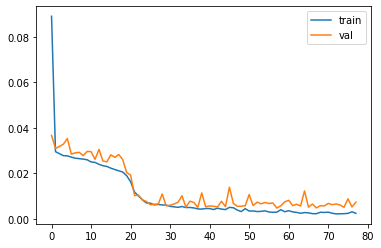

---Training time: 89.75074482 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto') 
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.95221, Train (V) - 0.95509
R2 scores: Validation (SS) - 0.84357, Validation (V) - 0.90804
R2 scores: Testing (SS) - -0.33253, Testing (V) - -3.08146
RMSE scores: Train (SS) - 0.04048, Train (V) - 0.02055
RMSE scores: Validation (SS) - 0.07991, Validation (V) - 0.03073
RMSE scores: Testing (SS) - 0.25279, Testing (V) - 0.23472


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

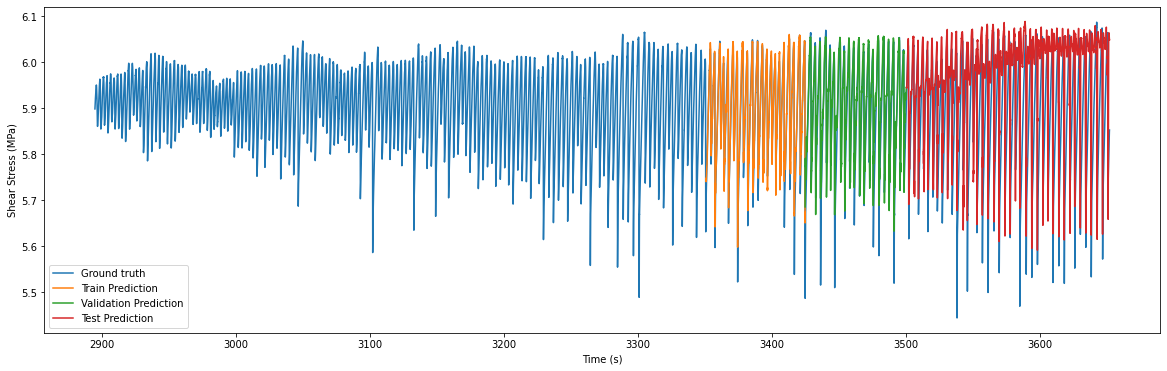

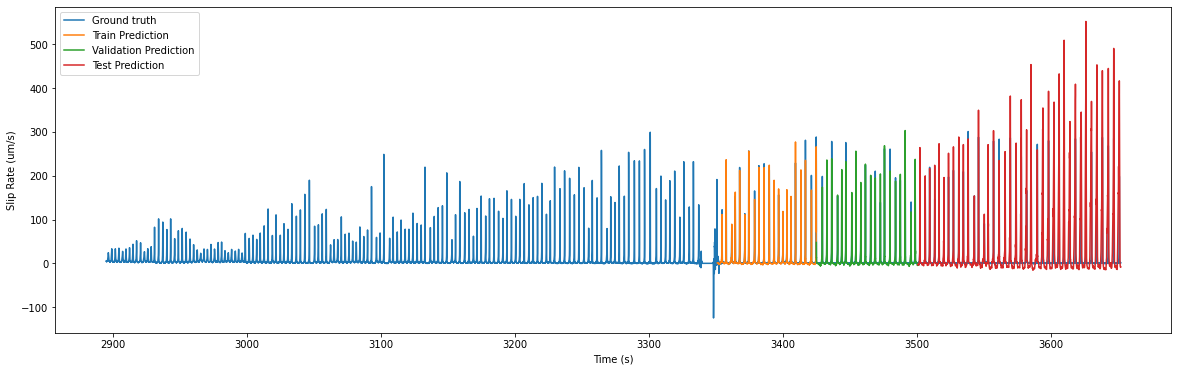

In [ ]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[45599:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

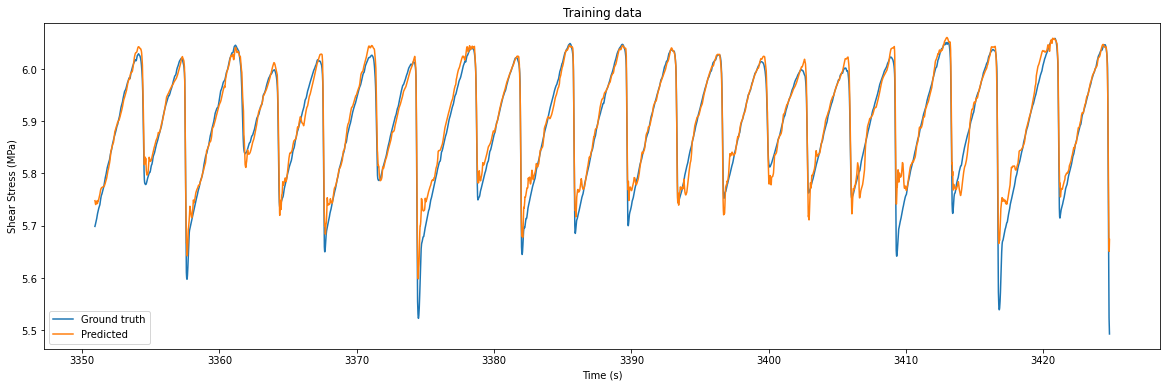

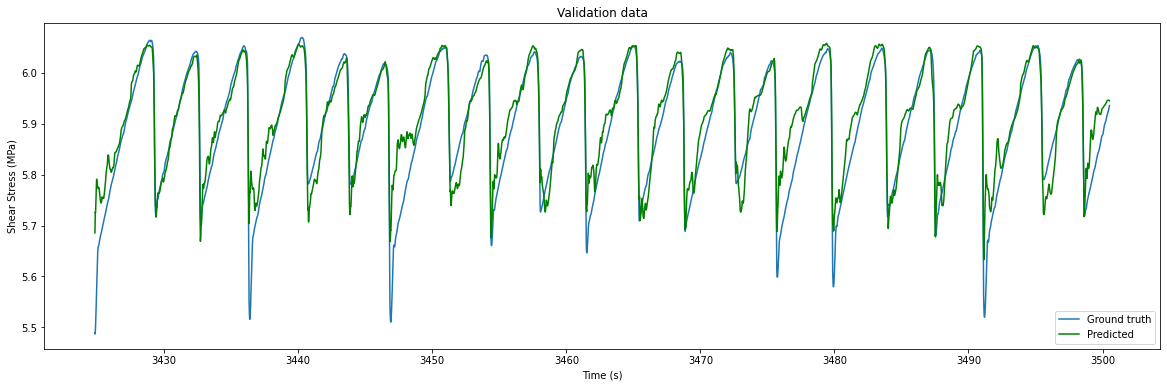

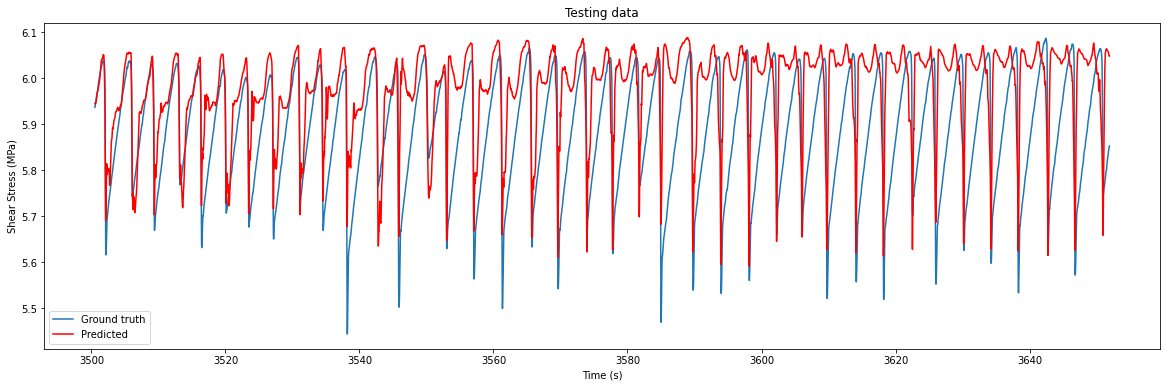

In [ ]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

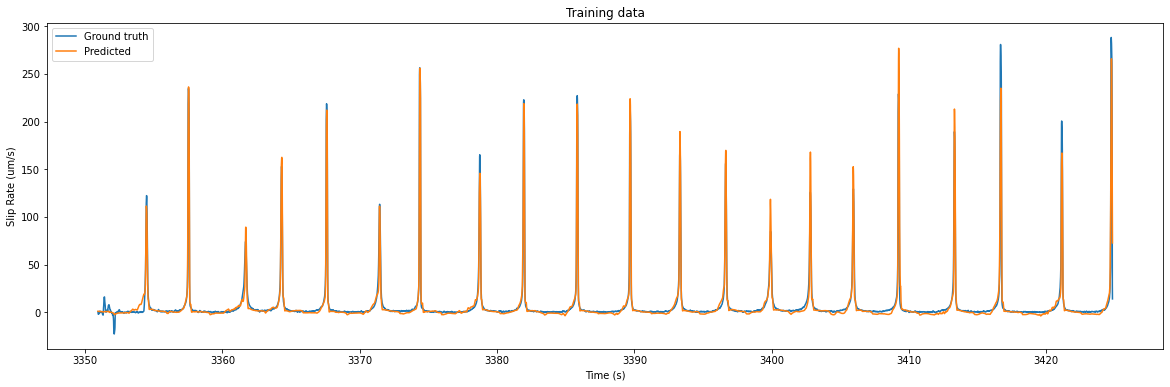

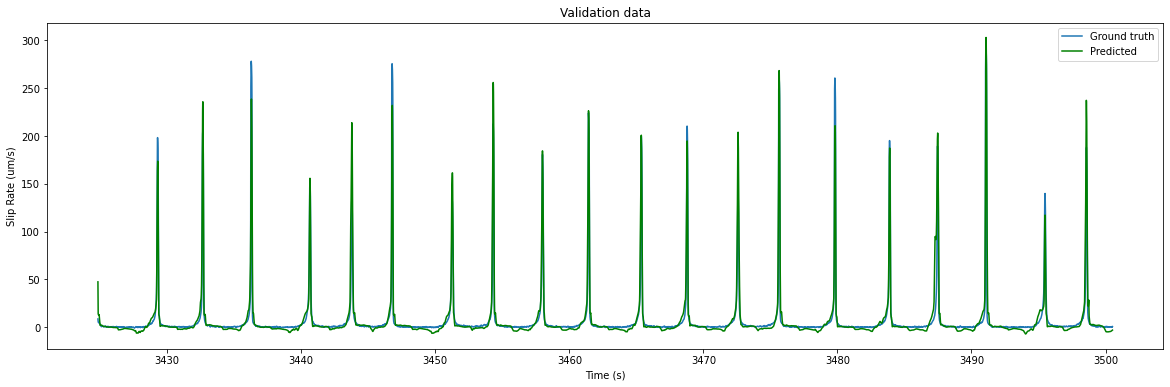

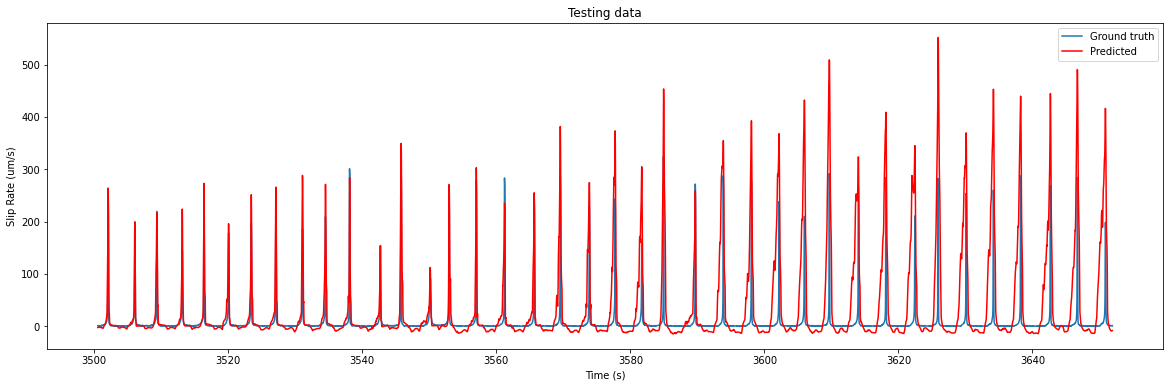

In [ ]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')